In [1]:
import pandas as pd
import numpy as np
import pyodbc as odbc

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


In [2]:
# Establish connection to SQL database
sql_conn = odbc.connect('DRIVER={ODBC Driver 17 for SQL Server};'
                        'SERVER=DESKTOP-3B6G2FC\MSSQLSERVER01;'
                        'DATABASE=supply_chain_1;'
                        'UID=Khalid;'
                        'PWD=246248246;')

# Load data from SQL
query = "SELECT * FROM fact_order_lines"
df = pd.read_sql(query, sql_conn)


C:\Users\PC\AppData\Local\Temp\ipykernel_4496\28412699.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, sql_conn)


In [3]:
# Check for null values
print("Null values in each column:")
print(df.isnull().sum())

# Check for duplicates
print(f"\nNumber of duplicate rows in the dataset: {df.duplicated().sum()}")


Null values in each column:
order_id                0
customer_id             0
product_id              0
order_qty               0
delivered_qty           0
order_placement_date    0
agreed_delivery_date    0
actual_delivery_date    0
dtype: int64

Number of duplicate rows in the dataset: 0


In [8]:
# Aggregate customer data
customer_features = df.groupby('customer_id').agg(
    avg_order_size=('order_qty', 'mean'),
    total_orders=('order_id', 'count'),
    total_delivered_qty=('delivered_qty', 'sum'),
    total_order_qty=('order_qty', 'sum'),
    order_frequency=('order_placement_date', 'nunique')
).reset_index()

# Merge the aggregated features back with the original dataframe
df = df.merge(customer_features, on='customer_id', how='left')

# Additional feature extraction

df['is_delayed'] = np.where(df['actual_delivery_date'] > df['agreed_delivery_date'], 1, 0)

df['is_fully_delivered'] = np.where(df['delivered_qty'] == df['order_qty'], 1, 0)

# Convert dates to datetime format
df['order_placement_date'] = pd.to_datetime(df['order_placement_date'])
df['agreed_delivery_date'] = pd.to_datetime(df['agreed_delivery_date'])
df['actual_delivery_date'] = pd.to_datetime(df['actual_delivery_date'])


In [9]:
# Select features and target variables
X = df[['avg_order_size', 'total_orders', 'total_delivered_qty', 'order_frequency']]
y_delay = df['is_delayed']
y_full_delivery = df['is_fully_delivered']
y_on_time_in_full = df['is_delayed'] & df['is_fully_delivered']  # Combined condition


In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train_delay, y_test_delay = train_test_split(X, y_delay, test_size=0.2, random_state=42)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y_full_delivery, test_size=0.2, random_state=42)
X_train_on_time, X_test_on_time, y_train_on_time, y_test_on_time = train_test_split(X, y_on_time_in_full, test_size=0.2, random_state=42)


In [11]:
# Step 5: Hyperparameter Tuning for Delay Prediction
# Cell 5: Define parameter grid for hyperparameter tuning for delay prediction
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Create and fit the model for delay prediction
# Removed use_label_encoder parameter
model_delay = XGBClassifier(eval_metric='logloss')
grid_search_delay = GridSearchCV(estimator=model_delay, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search_delay.fit(X_train, y_train_delay)


# Best parameters and score for delay prediction
print("Best Parameters for Delay Prediction:", grid_search_delay.best_params_)
print("Best Score for Delay Prediction:", grid_search_delay.best_score_)


Best Parameters for Delay Prediction: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
Best Score for Delay Prediction: 0.8190734556473741


In [12]:
# Cell 6: Hyperparameter Tuning for Full Delivery Prediction
grid_search_full = GridSearchCV(estimator=XGBClassifier(eval_metric='logloss'), 
                                 param_grid=param_grid, cv=3, scoring='accuracy')
grid_search_full.fit(X_train_full, y_train_full)

print("Best Parameters for Full Delivery Prediction:", grid_search_full.best_params_)
print("Best Score for Full Delivery Prediction:", grid_search_full.best_score_)


Best Parameters for Full Delivery Prediction: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best Score for Full Delivery Prediction: 0.7407828512732557


In [12]:
pip install --upgrade xgboost

Note: you may need to restart the kernel to use updated packages.


In [13]:
# Create and fit the model for on-time in full prediction
model_on_time = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
grid_search_on_time = GridSearchCV(estimator=model_on_time, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search_on_time.fit(X_train_on_time, y_train_on_time)

# Best parameters and score for on-time in full prediction
print("Best Parameters for On-Time In Full Prediction:", grid_search_on_time.best_params_)
print("Best Score for On-Time In Full Prediction:", grid_search_on_time.best_score_)


C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core

C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core

C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core

C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core

C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PC\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters for On-Time In Full Prediction: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300}
Best Score for On-Time In Full Prediction: 0.8333916454231524


In [14]:
# Predict and evaluate delay model
best_model_delay = grid_search_delay.best_estimator_
y_pred_delay = best_model_delay.predict(X_test)

print("\nDelay Prediction Report:")
print(classification_report(y_test_delay, y_pred_delay))

# Predict and evaluate full delivery model
best_model_full = grid_search_full.best_estimator_
y_pred_full = best_model_full.predict(X_test_full)

print("\nFull Delivery Prediction Report:")
print(classification_report(y_test_full, y_pred_full))

# Predict and evaluate on-time in full model
best_model_on_time = grid_search_on_time.best_estimator_
y_pred_on_time = best_model_on_time.predict(X_test_on_time)

print("\nOn-Time In Full Prediction Report:")
print(classification_report(y_test_on_time, y_pred_on_time))



Delay Prediction Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      8098
           1       0.74      0.58      0.65      3322

    accuracy                           0.82     11420
   macro avg       0.79      0.75      0.76     11420
weighted avg       0.81      0.82      0.81     11420


Full Delivery Prediction Report:
              precision    recall  f1-score   support

           0       0.69      0.41      0.51      3895
           1       0.75      0.90      0.82      7525

    accuracy                           0.73     11420
   macro avg       0.72      0.66      0.67     11420
weighted avg       0.73      0.73      0.71     11420


On-Time In Full Prediction Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      9370
           1       0.53      0.42      0.47      2050

    accuracy                           0.83     11420
   macro avg       0.71      0.6

<Figure size 1000x600 with 0 Axes>

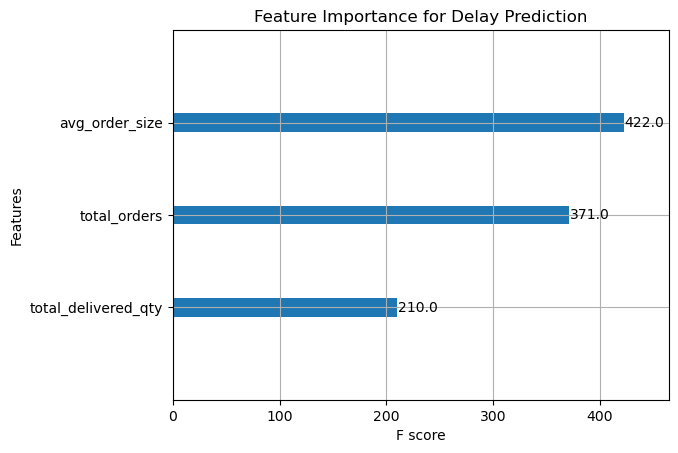

<Figure size 1000x600 with 0 Axes>

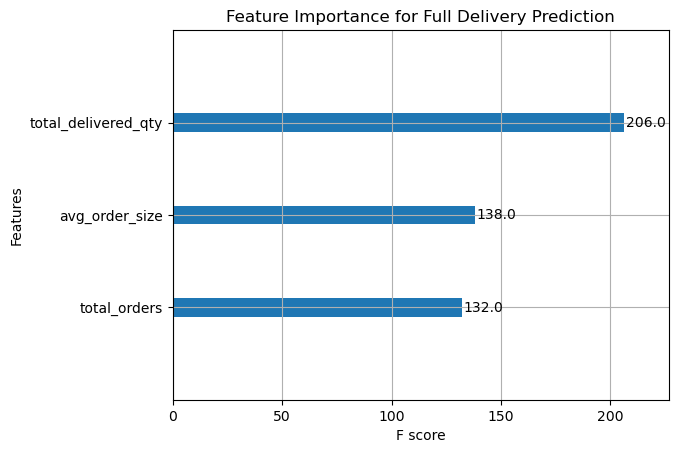

<Figure size 1000x600 with 0 Axes>

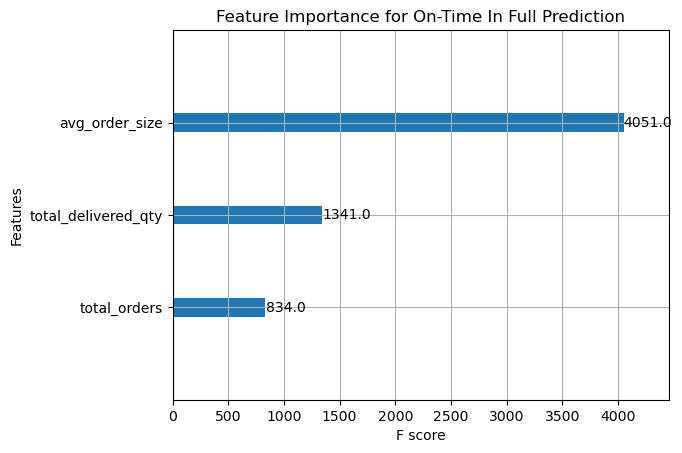

In [17]:
# Plot feature importance for the delay model
plt.figure(figsize=(10, 6))
plot_importance(best_model_delay)
plt.title("Feature Importance for Delay Prediction")
plt.show()

# Plot feature importance for the full delivery model
plt.figure(figsize=(10, 6))
plot_importance(best_model_full)
plt.title("Feature Importance for Full Delivery Prediction")
plt.show()

# Plot feature importance for the on-time in full model
plt.figure(figsize=(10, 6))
plot_importance(best_model_on_time)
plt.title("Feature Importance for On-Time In Full Prediction")
plt.show()
